In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_path = "data/processed_data.pkl"

data: pd.DataFrame = pd.read_pickle(data_path)
data.head()

# Do some basic filtering of the data
# For exampel paper https://iclr.cc/virtual/2025/poster/31514, has 450 coauthors, elading to a "kink" in the distribution
# Beyond the Imitation Game: Quantifying and extrapolating the capabilities of language models

# remove all paper where the number of authors is greater than 50, these skew the data too much
data = data[data["authors"].apply(len) <= 50]
# remove all papers where the number of authors is 1, they dont provide enough edge information
data = data[data["authors"].apply(len) >= 2]

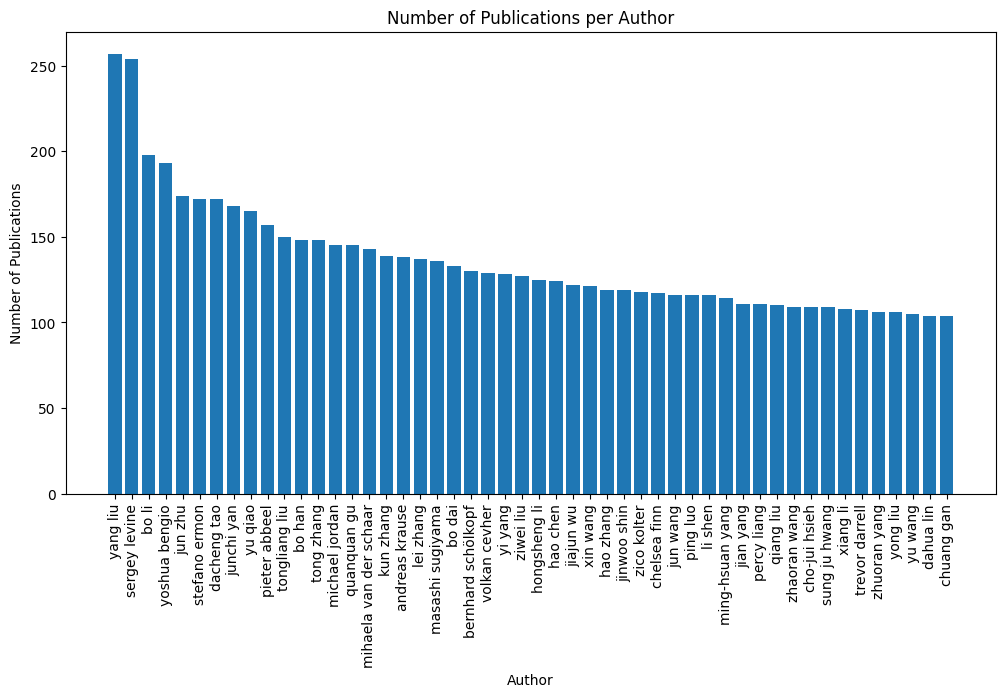

Number of unique authors: 90956


In [6]:
authors = data["authors"].to_list()

authors_flat = [author.strip().lower() for sublist in authors for author in sublist]
unique_authors, num_papers_per_author = np.unique(authors_flat, return_counts=True)

papers_per_author = {
    author: count for author, count in zip(unique_authors, num_papers_per_author)
}

# sort unique and counts by counts descending
sorted_indices = np.argsort(-num_papers_per_author)
unique_authors = unique_authors[sorted_indices]
num_papers_per_author = num_papers_per_author[sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(unique_authors[:50], num_papers_per_author[:50])
plt.xlabel("Author")
plt.ylabel("Number of Publications")
plt.title("Number of Publications per Author")
plt.xticks(rotation=90)
plt.show()

print("Number of unique authors:", len(unique_authors))

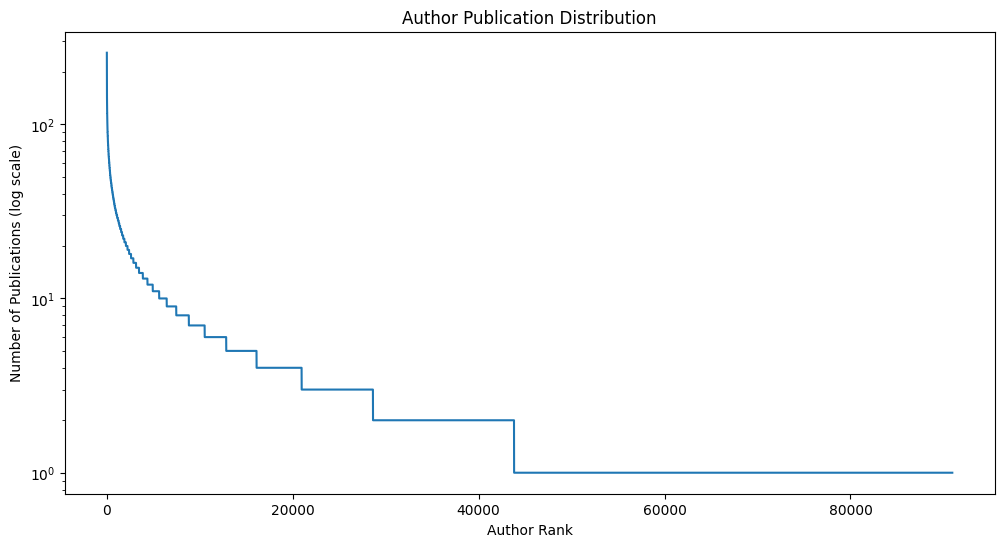

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(num_papers_per_author)
plt.yscale("log")
plt.xlabel("Author Rank")
plt.ylabel("Number of Publications (log scale)")
plt.title("Author Publication Distribution")
plt.show()

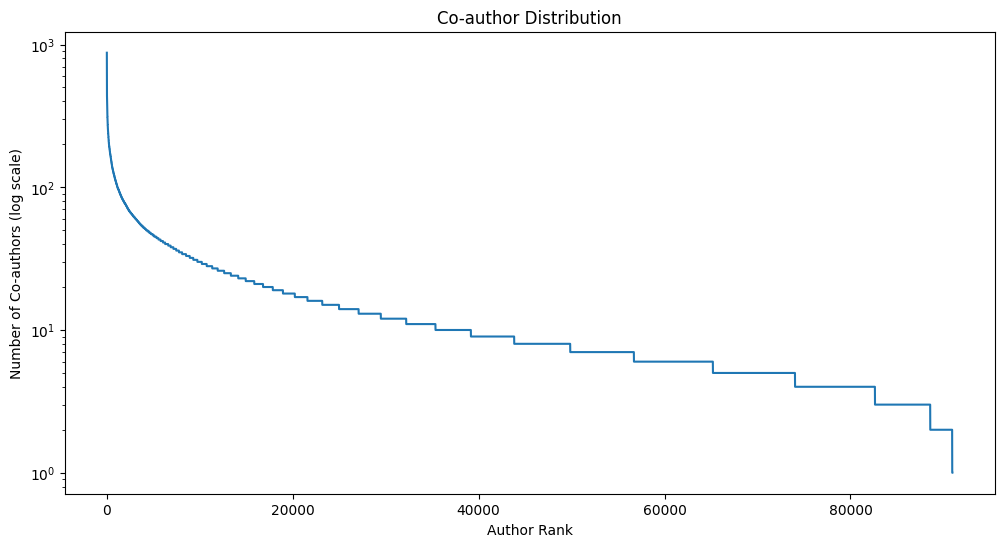

Author with most co-authors: yang liu with 876 co-authors


In [8]:
coauthors_per_author = {str(author): set() for author in unique_authors}
for coauthor_list in authors:
    for author in coauthor_list:
        author_norm = author.strip().lower()
        coauthors = set(coauthor_list) - {author_norm}
        coauthors_per_author[author_norm].update(coauthors)
        
num_coauthors_per_author = {
    author: len(coauthors) for author, coauthors in coauthors_per_author.items()
}

num_coauthors = np.array(list(num_coauthors_per_author.values()))
num_coauthors_sorted = np.sort(num_coauthors)[::-1]
plt.figure(figsize=(12, 6))
plt.plot(num_coauthors_sorted)
plt.yscale("log")
plt.xlabel("Author Rank")
plt.ylabel("Number of Co-authors (log scale)")
plt.title("Co-author Distribution")
plt.show()

# author with the most coauthors
top_author = unique_authors[np.argmax(num_coauthors)]
print(f"Author with most co-authors: {top_author} with {num_coauthors_per_author[top_author]} co-authors")

In [11]:
# get the clusters of the 10 most prolific authors
top_authors = unique_authors[:10]
top_author_indices = {author: [] for author in top_authors}
for i, coauthor_list in enumerate(authors):
    coauthor_list_norm = [author.strip().lower() for author in coauthor_list]
    for author in top_authors:
        if author in coauthor_list_norm:
            top_author_indices[author].append(i)

In [53]:
# embeddings = data["embedding"].to_list()
# embeddings = np.array(embeddings, dtype=np.float32)
# umap_reducer = umap.UMAP(n_components=2)
# embeddings_2d = umap_reducer.fit_transform(embeddings)

# top_author_embeddings = {
#     author: embeddings_2d[indices] for author, indices in top_author_indices.items()
# }
# top_author_colors = plt.cm.get_cmap("tab10", len(top_authors))

# plt.figure(figsize=(12, 8))
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=1, alpha=0.5)

# for author, emb in top_author_embeddings.items():
#     plt.scatter(
#         emb[:, 0],
#         emb[:, 1],
#         s=10,
#         c=top_author_colors(top_authors.tolist().index(author)),
#     )
# plt.title("2D UMAP Projection of Paper Embeddings")
# plt.xlabel("UMAP Dimension 1")
# plt.ylabel("UMAP Dimension 2")
# plt.show()

In [ ]:
# Get the number of edges in the Graph
# Edge Types:
# - Autor to Author (Coauthor edges)
# - Author to Paper (Authorship edges)

num_coauthor_edges = 0
for coauthor_list in authors:
    # each paper comes with a clique of authors
    n = len(coauthor_list)
    num_coauthor_edges += n * (n - 1) // 2  # number of edges in a complete graph of n nodes
    
# Each paper introduces one edge from each author to the paper
num_authorship_edges = sum(len(coauthor_list) for coauthor_list in authors)

# Nodes are authors and papers
# Node Types:
# - Author Nodes
# - Paper Nodes

num_author_nodes = len(unique_authors)
num_paper_nodes = len(data)

print(f"Total number of Coauthor edges: {num_coauthor_edges}")
print(f"Total number of Authorship edges: {num_authorship_edges}")
print(f"Total number of edges in the graph: {num_coauthor_edges + num_authorship_edges}")
print("-------------------------------")
print(f"Total number of Author nodes: {num_author_nodes}")
print(f"Total number of Paper nodes: {num_paper_nodes}")
print(f"Total number of nodes in the graph: {num_author_nodes + num_paper_nodes}")

Total number of Coauthor edges: 871927
Total number of Authorship edges: 320228
Total number of edges in the graph: 1192155
-------------------------------
Total number of Author nodes: 90956
Total number of Paper nodes: 63861
Total number of nodes in the graph: 154817
